In [1]:
from setup_extended_corpus import build_corpora
corpora = build_corpora()
#print(corpora)

[nltk_data] Downloading package treebank to
[nltk_data]     /Users/sharadsharma/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


Selected Category: extended_description
extended_description has 414 samples;
extended_installation has 103 samples;
extended_invocation has 103 samples;
extended_citation has 103 samples;
Selected Category: extended_installation
extended_description has 274 samples;
extended_installation has 1096 samples;
extended_invocation has 274 samples;
extended_citation has 274 samples;
Selected Category: extended_invocation
extended_description has 380 samples;
extended_installation has 380 samples;
extended_invocation has 1523 samples;
extended_citation has 380 samples;
Selected Category: extended_citation
extended_description has 102 samples;
extended_installation has 102 samples;
extended_invocation has 102 samples;
extended_citation has 409 samples;


# We try out the top 4 models for invocation on our extended corpus

In [18]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate,StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
from sklearn.metrics import precision_score,recall_score,roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import re
from sklearn.model_selection import GridSearchCV
import nltk
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

ext_invo=corpora['extended_invocation']
#del ext_invo['Unnamed: 0']

X_invo, Y_invo = ext_invo.excerpt, ext_invo.extended_invocation



## 1) TfidfVectorizer + NaiveBayes

              precision    recall  f1-score   support

       False       0.90      0.81      0.85       288
        True       0.86      0.93      0.90       378

    accuracy                           0.88       666
   macro avg       0.88      0.87      0.87       666
weighted avg       0.88      0.88      0.88       666

null accuracy: 56.76%
accuracy score: 87.84%
model is 31.08% more accurate than null accuracy


accuracy score: 87.84%
Precision score : 0.8648648648648649
Recall score  : 0.9312169312169312


[0.73545966 0.78611632 0.74108818 0.83270677 0.81015038]
Mean accuracy of CV: 0.7811042615920665
Invocation ROC


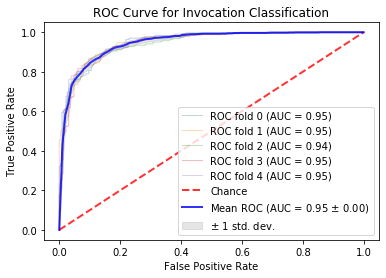

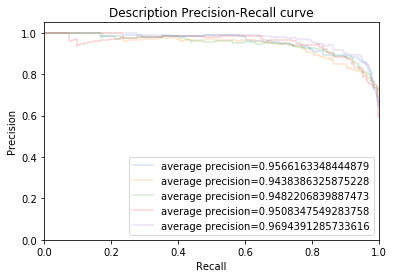

In [22]:
pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())
X_train, X_test, Y_train, Y_test = train_test_split(X_invo, Y_invo)


def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)
y_pred_vals = pipeline.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})

print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv = StratifiedKFold(n_splits = 5, shuffle=True)

cv_results = cross_validate(pipeline, X_invo, Y_invo, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
    
i = 0
print('Invocation ROC')
for train, test in cv.split(X_invo, Y_invo):
    probas_ = pipeline.fit(X_invo[train], Y_invo[train]).predict_proba(X_invo[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(Y_invo[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Invocation Classification')
plt.legend(loc="lower right")
plt.show()


for train, test in cv.split(X_invo, Y_invo):
    probas_ = pipeline.fit(X_invo[train], Y_invo[train]).predict_proba(X_invo[test])
    precision, recall, _ = precision_recall_curve(Y_invo[test], probas_[:,1])

    plt.step(recall, precision, alpha=0.2,
             where='post', label=f'average precision={average_precision_score(Y_invo[test], probas_[:,1])}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Description Precision-Recall curve'.format(
          average_precision_score(Y_invo[test], probas_[:,1])))
plt.legend(loc="lower right")
plt.show()





## 2) CountVectorizer + NaiveBayes

              precision    recall  f1-score   support

       False       0.85      0.83      0.84       288
        True       0.87      0.89      0.88       378

    accuracy                           0.86       666
   macro avg       0.86      0.86      0.86       666
weighted avg       0.86      0.86      0.86       666

null accuracy: 56.76%
accuracy score: 86.34%
model is 29.58% more accurate than null accuracy


accuracy score: 86.34%
Precision score : 0.8708010335917312
Recall score  : 0.8915343915343915


[0.7467167  0.75984991 0.75046904 0.78195489 0.76879699]
Mean accuracy of CV: 0.7615575053957595
Invocation ROC


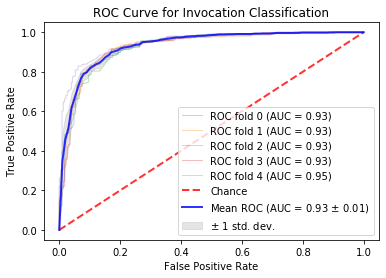

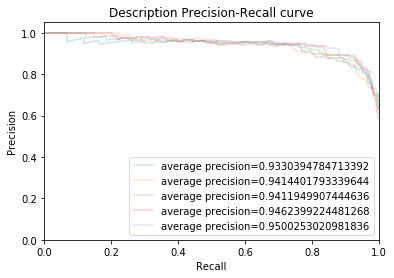

In [23]:
pipeline = make_pipeline(CountVectorizer(), MultinomialNB())
X_train, X_test, Y_train, Y_test = train_test_split(X_invo, Y_invo)


def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)
y_pred_vals = pipeline.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})

print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv = StratifiedKFold(n_splits = 5, shuffle=True)

cv_results = cross_validate(pipeline, X_invo, Y_invo, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
    
i = 0
print('Invocation ROC')
for train, test in cv.split(X_invo, Y_invo):
    probas_ = pipeline.fit(X_invo[train], Y_invo[train]).predict_proba(X_invo[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(Y_invo[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Invocation Classification')
plt.legend(loc="lower right")
plt.show()


for train, test in cv.split(X_invo, Y_invo):
    probas_ = pipeline.fit(X_invo[train], Y_invo[train]).predict_proba(X_invo[test])
    precision, recall, _ = precision_recall_curve(Y_invo[test], probas_[:,1])

    plt.step(recall, precision, alpha=0.2,
             where='post', label=f'average precision={average_precision_score(Y_invo[test], probas_[:,1])}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Description Precision-Recall curve'.format(
          average_precision_score(Y_invo[test], probas_[:,1])))
plt.legend(loc="lower right")
plt.show()






## 3) TfidfVectorizer + StochasticGradientDescent

              precision    recall  f1-score   support

       False       0.92      0.76      0.83       295
        True       0.83      0.95      0.89       371

    accuracy                           0.86       666
   macro avg       0.88      0.85      0.86       666
weighted avg       0.87      0.86      0.86       666

null accuracy: 55.71%
accuracy score: 86.49%
model is 30.78% more accurate than null accuracy


accuracy score: 86.49%
Precision score : 0.8321513002364066
Recall score  : 0.9487870619946092


[0.76172608 0.76923077 0.75234522 0.81766917 0.81015038]
Mean accuracy of CV: 0.7822243225324098
Invocation ROC


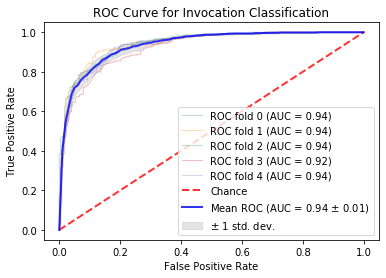

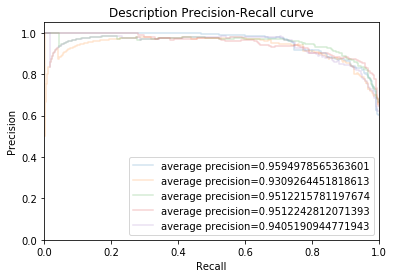

In [28]:
pipeline = make_pipeline(TfidfVectorizer(), SGDClassifier(loss='log'))
X_train, X_test, Y_train, Y_test = train_test_split(X_invo, Y_invo)


def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)
y_pred_vals = pipeline.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})

print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv = StratifiedKFold(n_splits = 5, shuffle=True)

cv_results = cross_validate(pipeline, X_invo, Y_invo, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
    
i = 0
print('Invocation ROC')
for train, test in cv.split(X_invo, Y_invo):
    probas_ = pipeline.fit(X_invo[train], Y_invo[train]).predict_proba(X_invo[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(Y_invo[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Invocation Classification')
plt.legend(loc="lower right")
plt.show()


for train, test in cv.split(X_invo, Y_invo):
    probas_ = pipeline.fit(X_invo[train], Y_invo[train]).predict_proba(X_invo[test])
    precision, recall, _ = precision_recall_curve(Y_invo[test], probas_[:,1])

    plt.step(recall, precision, alpha=0.2,
             where='post', label=f'average precision={average_precision_score(Y_invo[test], probas_[:,1])}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Description Precision-Recall curve'.format(
          average_precision_score(Y_invo[test], probas_[:,1])))
plt.legend(loc="lower right")
plt.show()






## 4) CountVectorizer + LogisticRegression

              precision    recall  f1-score   support

       False       0.91      0.75      0.82       294
        True       0.83      0.94      0.88       372

    accuracy                           0.86       666
   macro avg       0.87      0.84      0.85       666
weighted avg       0.86      0.86      0.85       666

null accuracy: 55.86%
accuracy score: 85.59%
model is 29.73% more accurate than null accuracy


accuracy score: 85.59%
Precision score : 0.8254716981132075
Recall score  : 0.9408602150537635


[0.77861163 0.78236398 0.72795497 0.83834586 0.83082707]
Mean accuracy of CV: 0.7916207027888671
Invocation ROC


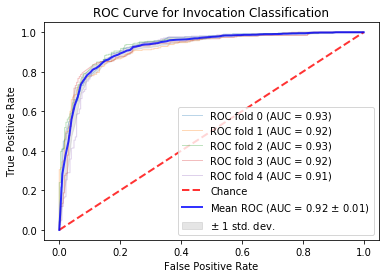

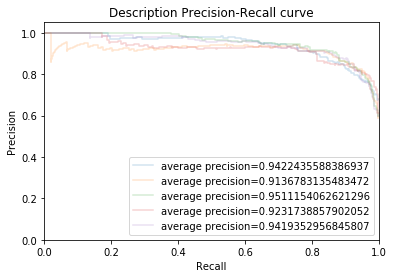

In [32]:
pipeline = make_pipeline(CountVectorizer(), LogisticRegression(solver='liblinear'))
X_train, X_test, Y_train, Y_test = train_test_split(X_invo, Y_invo)


def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)
y_pred_vals = pipeline.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})

print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv = StratifiedKFold(n_splits = 5, shuffle=True)

cv_results = cross_validate(pipeline, X_invo, Y_invo, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
    
i = 0
print('Invocation ROC')
for train, test in cv.split(X_invo, Y_invo):
    probas_ = pipeline.fit(X_invo[train], Y_invo[train]).predict_proba(X_invo[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(Y_invo[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Invocation Classification')
plt.legend(loc="lower right")
plt.show()


for train, test in cv.split(X_invo, Y_invo):
    probas_ = pipeline.fit(X_invo[train], Y_invo[train]).predict_proba(X_invo[test])
    precision, recall, _ = precision_recall_curve(Y_invo[test], probas_[:,1])

    plt.step(recall, precision, alpha=0.2,
             where='post', label=f'average precision={average_precision_score(Y_invo[test], probas_[:,1])}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Description Precision-Recall curve'.format(
          average_precision_score(Y_invo[test], probas_[:,1])))
plt.legend(loc="lower right")
plt.show()







# We shall now remove the stopwords and re-run our models

In [7]:
def remove_stopwords(x):
    tokens = nltk.word_tokenize(x)
    tokens=[i for i in tokens if i not in stop_words]
    res=' '.join(tokens)
    
    return res

ext_invo=corpora['extended_invocation']
#del ext_invo['Unnamed: 0']
ext_invo['excerpt'] = ext_invo['excerpt'].apply(remove_stopwords)

X_invo, Y_invo = ext_invo.excerpt, ext_invo.extended_invocation

## 1) TfidfVectorizer + NaiveBayes

              precision    recall  f1-score   support

       False       0.92      0.76      0.84       289
        True       0.84      0.95      0.89       377

    accuracy                           0.87       666
   macro avg       0.88      0.86      0.86       666
weighted avg       0.88      0.87      0.87       666

null accuracy: 56.61%
accuracy score: 86.94%
model is 30.33% more accurate than null accuracy


accuracy score: 86.94%
Precision score : 0.8403755868544601
Recall score  : 0.9496021220159151


[0.70356473 0.75422139 0.74859287 0.81203008 0.81578947]
Mean accuracy of CV: 0.7668397071477944
Invocation ROC


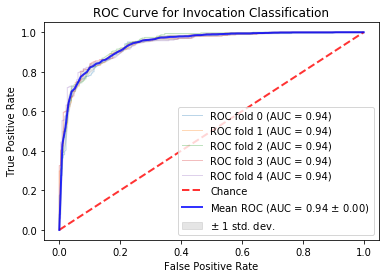

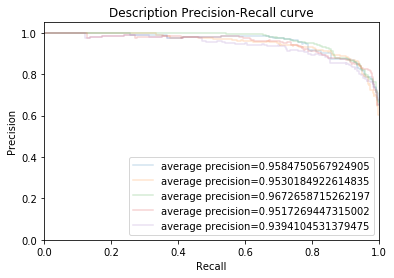

In [18]:
pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())
X_train, X_test, Y_train, Y_test = train_test_split(X_invo, Y_invo)


def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)
y_pred_vals = pipeline.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})

print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv = StratifiedKFold(n_splits = 5, shuffle=True)

cv_results = cross_validate(pipeline, X_invo, Y_invo, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
    
i = 0
print('Invocation ROC')
for train, test in cv.split(X_invo, Y_invo):
    probas_ = pipeline.fit(X_invo[train], Y_invo[train]).predict_proba(X_invo[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(Y_invo[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Invocation Classification')
plt.legend(loc="lower right")
plt.show()


for train, test in cv.split(X_invo, Y_invo):
    probas_ = pipeline.fit(X_invo[train], Y_invo[train]).predict_proba(X_invo[test])
    precision, recall, _ = precision_recall_curve(Y_invo[test], probas_[:,1])

    plt.step(recall, precision, alpha=0.2,
             where='post', label=f'average precision={average_precision_score(Y_invo[test], probas_[:,1])}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Description Precision-Recall curve'.format(
          average_precision_score(Y_invo[test], probas_[:,1])))
plt.legend(loc="lower right")
plt.show()






## 2) CountVectorizer + NaiveBayes

              precision    recall  f1-score   support

       False       0.89      0.81      0.85       294
        True       0.86      0.92      0.89       372

    accuracy                           0.87       666
   macro avg       0.87      0.87      0.87       666
weighted avg       0.87      0.87      0.87       666

null accuracy: 55.86%
accuracy score: 87.24%
model is 31.38% more accurate than null accuracy


accuracy score: 87.24%
Precision score : 0.8614609571788413
Recall score  : 0.9193548387096774


[0.72045028 0.77110694 0.74296435 0.77255639 0.77631579]
Mean accuracy of CV: 0.7566787512872237
Invocation ROC


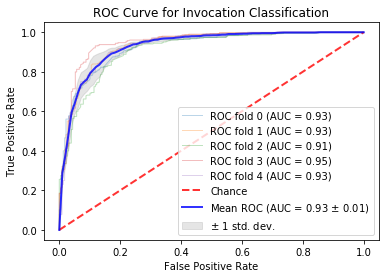

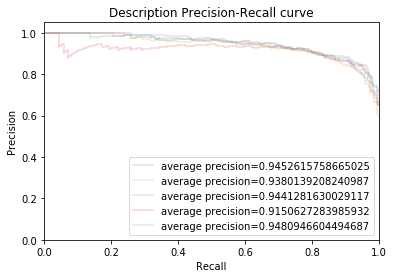

In [23]:
pipeline = make_pipeline(CountVectorizer(), MultinomialNB())
X_train, X_test, Y_train, Y_test = train_test_split(X_invo, Y_invo)


def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)
y_pred_vals = pipeline.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})

print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv = StratifiedKFold(n_splits = 5, shuffle=True)

cv_results = cross_validate(pipeline, X_invo, Y_invo, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
    
i = 0
print('Invocation ROC')
for train, test in cv.split(X_invo, Y_invo):
    probas_ = pipeline.fit(X_invo[train], Y_invo[train]).predict_proba(X_invo[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(Y_invo[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Invocation Classification')
plt.legend(loc="lower right")
plt.show()


for train, test in cv.split(X_invo, Y_invo):
    probas_ = pipeline.fit(X_invo[train], Y_invo[train]).predict_proba(X_invo[test])
    precision, recall, _ = precision_recall_curve(Y_invo[test], probas_[:,1])

    plt.step(recall, precision, alpha=0.2,
             where='post', label=f'average precision={average_precision_score(Y_invo[test], probas_[:,1])}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Description Precision-Recall curve'.format(
          average_precision_score(Y_invo[test], probas_[:,1])))
plt.legend(loc="lower right")
plt.show()







## 3) TfidfVectorizer + StochasticGradientDescent

              precision    recall  f1-score   support

       False       0.86      0.80      0.83       279
        True       0.86      0.91      0.89       387

    accuracy                           0.86       666
   macro avg       0.86      0.85      0.86       666
weighted avg       0.86      0.86      0.86       666

null accuracy: 58.11%
accuracy score: 86.34%
model is 28.23% more accurate than null accuracy


accuracy score: 86.34%
Precision score : 0.8627450980392157
Recall score  : 0.9095607235142119


[0.74296435 0.7804878  0.76172608 0.78759398 0.79135338]
Mean accuracy of CV: 0.7728251209637602
Invocation ROC


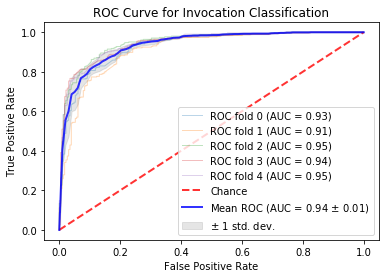

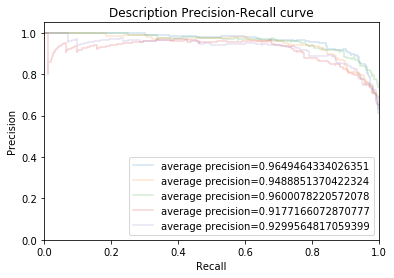

In [26]:
pipeline = make_pipeline(TfidfVectorizer(), SGDClassifier(loss='log'))
X_train, X_test, Y_train, Y_test = train_test_split(X_invo, Y_invo)


def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)
y_pred_vals = pipeline.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})

print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv = StratifiedKFold(n_splits = 5, shuffle=True)

cv_results = cross_validate(pipeline, X_invo, Y_invo, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
    
i = 0
print('Invocation ROC')
for train, test in cv.split(X_invo, Y_invo):
    probas_ = pipeline.fit(X_invo[train], Y_invo[train]).predict_proba(X_invo[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(Y_invo[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Invocation Classification')
plt.legend(loc="lower right")
plt.show()


for train, test in cv.split(X_invo, Y_invo):
    probas_ = pipeline.fit(X_invo[train], Y_invo[train]).predict_proba(X_invo[test])
    precision, recall, _ = precision_recall_curve(Y_invo[test], probas_[:,1])

    plt.step(recall, precision, alpha=0.2,
             where='post', label=f'average precision={average_precision_score(Y_invo[test], probas_[:,1])}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Description Precision-Recall curve'.format(
          average_precision_score(Y_invo[test], probas_[:,1])))
plt.legend(loc="lower right")
plt.show()







## 4) CountVectorizer + LogisticRegression

              precision    recall  f1-score   support

       False       0.92      0.72      0.81       268
        True       0.84      0.95      0.89       398

    accuracy                           0.86       666
   macro avg       0.88      0.84      0.85       666
weighted avg       0.87      0.86      0.86       666

null accuracy: 59.76%
accuracy score: 86.19%
model is 26.43% more accurate than null accuracy


accuracy score: 86.19%
Precision score : 0.8370044052863436
Recall score  : 0.9547738693467337


[0.7673546  0.77298311 0.75422139 0.82142857 0.82142857]
Mean accuracy of CV: 0.7874832484588582
Invocation ROC


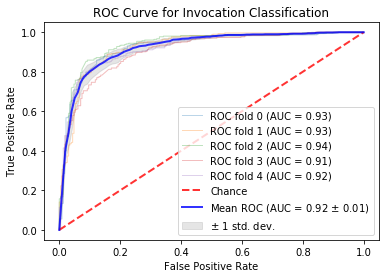

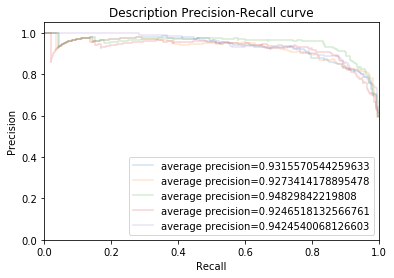

In [36]:
pipeline = make_pipeline(CountVectorizer(), LogisticRegression(solver='liblinear'))
X_train, X_test, Y_train, Y_test = train_test_split(X_invo, Y_invo)


def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)
y_pred_vals = pipeline.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})

print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv = StratifiedKFold(n_splits = 5, shuffle=True)

cv_results = cross_validate(pipeline, X_invo, Y_invo, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
    
i = 0
print('Invocation ROC')
for train, test in cv.split(X_invo, Y_invo):
    probas_ = pipeline.fit(X_invo[train], Y_invo[train]).predict_proba(X_invo[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(Y_invo[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Invocation Classification')
plt.legend(loc="lower right")
plt.show()


for train, test in cv.split(X_invo, Y_invo):
    probas_ = pipeline.fit(X_invo[train], Y_invo[train]).predict_proba(X_invo[test])
    precision, recall, _ = precision_recall_curve(Y_invo[test], probas_[:,1])

    plt.step(recall, precision, alpha=0.2,
             where='post', label=f'average precision={average_precision_score(Y_invo[test], probas_[:,1])}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Description Precision-Recall curve'.format(
          average_precision_score(Y_invo[test], probas_[:,1])))
plt.legend(loc="lower right")
plt.show()








## Trying out cross validation and hyperparameter tuning

### 1) TfidfVectorizer + NaiveBayes

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X_invo, Y_invo)

pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())
params={'multinomialnb__alpha':[0.001,0.01,0.1,1,10,100,1000]}

clf_ridge_cv = GridSearchCV(pipeline, param_grid=params,scoring='accuracy',cv=StratifiedKFold(5))
clf_ridge_cv.fit(X_train, Y_train)

print("We get the best CV score of:",clf_ridge_cv.best_score_," when the parameters are:", clf_ridge_cv.best_params_)

pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha=clf_ridge_cv.best_params_['multinomialnb__alpha']))

def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)

print(confusion_matrix(Y_test, y_pred_class))
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))






We get the best CV score of: 0.8713283208020052  when the parameters are: {'multinomialnb__alpha': 0.1}
[[241  44]
 [ 30 351]]
              precision    recall  f1-score   support

       False       0.89      0.85      0.87       285
        True       0.89      0.92      0.90       381

    accuracy                           0.89       666
   macro avg       0.89      0.88      0.89       666
weighted avg       0.89      0.89      0.89       666

null accuracy: 57.21%
accuracy score: 88.89%
model is 31.68% more accurate than null accuracy


accuracy score: 88.89%
Precision score : 0.8886075949367088
Recall score  : 0.9212598425196851


### 2) CountVectorizer + NaiveBayes

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X_invo, Y_invo)

pipeline = make_pipeline(CountVectorizer(), MultinomialNB())
params={'multinomialnb__alpha':[0.001,0.01,0.1,1,10,100,1000]}

clf_ridge_cv = GridSearchCV(pipeline, param_grid=params,scoring='accuracy',cv=StratifiedKFold(5))
clf_ridge_cv.fit(X_train, Y_train)

print("We get the best CV score of:",clf_ridge_cv.best_score_," when the parameters are:", clf_ridge_cv.best_params_)

pipeline = make_pipeline(CountVectorizer(), MultinomialNB(alpha=clf_ridge_cv.best_params_['multinomialnb__alpha']))

def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)

print(confusion_matrix(Y_test, y_pred_class))
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))







We get the best CV score of: 0.8642969924812031  when the parameters are: {'multinomialnb__alpha': 1}
[[232  39]
 [ 37 358]]
              precision    recall  f1-score   support

       False       0.86      0.86      0.86       271
        True       0.90      0.91      0.90       395

    accuracy                           0.89       666
   macro avg       0.88      0.88      0.88       666
weighted avg       0.89      0.89      0.89       666

null accuracy: 59.31%
accuracy score: 88.59%
model is 29.28% more accurate than null accuracy


accuracy score: 88.59%
Precision score : 0.9017632241813602
Recall score  : 0.9063291139240506


### 3) TFIDFVectorizer + StochasticGradientDescent

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X_invo, Y_invo)

#pipeline = make_pipeline(TfidfVectorizer(), SGDClassifier())
#params={'sgdclassifier__loss':['hinge', 'log', 'modified_huber', 'squared_hinge'],'sgdclassifier__alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000],
#       'sgdclassifier__penalty':['l2', 'l1', 'elasticnet']}

#clf_ridge_cv = GridSearchCV(pipeline, param_grid=params,scoring='accuracy',cv=StratifiedKFold(5))
#clf_ridge_cv.fit(X_train, Y_train)

#We get the best CV score of: 0.856781954887218  when the parameters are: {'sgdclassifier__alpha': 0.0001, 'sgdclassifier__loss': 'log', 'sgdclassifier__penalty': 'l2'}

#print("We get the best CV score of:",clf_ridge_cv.best_score_," when the parameters are:", clf_ridge_cv.best_params_)


pipeline = make_pipeline(TfidfVectorizer(), SGDClassifier(loss='log',alpha=0.0001,penalty='l2'))

def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)

print(confusion_matrix(Y_test, y_pred_class))
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))


[[226  68]
 [ 34 338]]
              precision    recall  f1-score   support

       False       0.87      0.77      0.82       294
        True       0.83      0.91      0.87       372

    accuracy                           0.85       666
   macro avg       0.85      0.84      0.84       666
weighted avg       0.85      0.85      0.85       666

null accuracy: 55.86%
accuracy score: 84.68%
model is 28.83% more accurate than null accuracy


accuracy score: 84.68%
Precision score : 0.8325123152709359
Recall score  : 0.9086021505376344


### 4) CountVectorizer+LogisticRegression

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X_invo, Y_invo)

pipeline = make_pipeline(CountVectorizer(), LogisticRegression(penalty='l2',solver='liblinear'))
params={'logisticregression__C':[0.001,0.01,0.1,1,10,100,1000]}
clf_ridge_cv = GridSearchCV(pipeline, param_grid=params,scoring='accuracy',cv=StratifiedKFold(5))
clf_ridge_cv.fit(X_train, Y_train)

print("We get the best CV score of:",clf_ridge_cv.best_score_," when the parameters are:", clf_ridge_cv.best_params_)

pipeline = make_pipeline(CountVectorizer(), LogisticRegression(penalty='l2',C=clf_ridge_cv.best_params_['logisticregression__C'],solver='liblinear'))

def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)

print(confusion_matrix(Y_test, y_pred_class))
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))




We get the best CV score of: 0.8497756892230577  when the parameters are: {'logisticregression__C': 10}
[[215  77]
 [ 30 344]]
              precision    recall  f1-score   support

       False       0.88      0.74      0.80       292
        True       0.82      0.92      0.87       374

    accuracy                           0.84       666
   macro avg       0.85      0.83      0.83       666
weighted avg       0.84      0.84      0.84       666

null accuracy: 56.16%
accuracy score: 83.93%
model is 27.78% more accurate than null accuracy


accuracy score: 83.93%
Precision score : 0.8171021377672208
Recall score  : 0.9197860962566845


### 5) TFIDFVectorizer + RandomForest (with tuning of hyp)

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X_invo, Y_invo)

#pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
#params={'randomforestclassifier__n_estimators':range(100,200,20),'randomforestclassifier__max_depth':range(3,10,2),'randomforestclassifier__max_features':["auto", "sqrt", "log2"]}
#clf_ridge_cv = GridSearchCV(pipeline, param_grid=params,scoring='accuracy',cv=StratifiedKFold(5))
#clf_ridge_cv.fit(X_train, Y_train)

#print("We get the best CV score of:",clf_ridge_cv.best_score_," when the parameters are:", clf_ridge_cv.best_params_)
#We get the best CV score of: 0.6935426065162906  when the parameters are: {'randomforestclassifier__max_depth': 9, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__n_estimators': 140}

pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier(max_depth=9,max_features='auto',n_estimators=140))

def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)

print(confusion_matrix(Y_test, y_pred_class))
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))



[[101 194]
 [ 15 356]]
              precision    recall  f1-score   support

       False       0.87      0.34      0.49       295
        True       0.65      0.96      0.77       371

    accuracy                           0.69       666
   macro avg       0.76      0.65      0.63       666
weighted avg       0.75      0.69      0.65       666

null accuracy: 55.71%
accuracy score: 68.62%
model is 12.91% more accurate than null accuracy


accuracy score: 68.62%
Precision score : 0.6472727272727272
Recall score  : 0.9595687331536388


## Using feature selection measure on top models

### TfidfVectorizer+MultinomialNB

In [76]:
X_train, X_test, Y_train, Y_test = train_test_split(X_invo, Y_invo)

pipeline = make_pipeline(TfidfVectorizer(),SelectFromModel(LinearSVC(penalty="l1", dual=False)), MultinomialNB())
params={'multinomialnb__alpha':[0.001,0.01,0.1,1,10,100,1000]}

clf_ridge_cv = GridSearchCV(pipeline, param_grid=params,scoring='accuracy',cv=StratifiedKFold(5))
clf_ridge_cv.fit(X_train, Y_train)

print("We get the best CV score of:",clf_ridge_cv.best_score_," when the parameters are:", clf_ridge_cv.best_params_)

pipeline = make_pipeline(TfidfVectorizer(),SelectFromModel(LinearSVC(penalty="l1", dual=False)), MultinomialNB(alpha=clf_ridge_cv.best_params_['multinomialnb__alpha']))

def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)

print(confusion_matrix(Y_test, y_pred_class))
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))








We get the best CV score of: 0.844766917293233  when the parameters are: {'multinomialnb__alpha': 0.1}
[[224  77]
 [ 22 343]]
              precision    recall  f1-score   support

       False       0.91      0.74      0.82       301
        True       0.82      0.94      0.87       365

    accuracy                           0.85       666
   macro avg       0.86      0.84      0.85       666
weighted avg       0.86      0.85      0.85       666

null accuracy: 54.80%
accuracy score: 85.14%
model is 30.33% more accurate than null accuracy


accuracy score: 85.14%
Precision score : 0.8166666666666667
Recall score  : 0.9397260273972603
